# TP 2: Expectation-Maximisation algorithm – Importance sampling

### Vincent HERFELD

## Exercise 1: Discrete distributions

### Question 1 :

Given a set $\{x_1, x_2, ..., x_n\}$ and $(p_i)_{i\in \{1,..,n\}}$ we would like to simulate the random variable $X$ such that $\forall i \in \{1,...,n\},\; \mathbb{P}(X = x_i) = p_i$. 

We can use the inversion theorem and simulate a uniform variable $U \sim \mathcal{U}([0,1])$ and then set $X = F^{-1}(U)$, where $F^{-1}(u) = x_1\mathbb{1}_{[0, p_1]}(u) + \sum_{j=1}^{n-1} x_{j+1} \mathbb{1}_{[\sum_{k =1}^{j} p_k, \sum_{k =1}^{j+1} p_k]}(u) $ 

### Question 2 :

In [773]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

In [1405]:
def F_inv(u, x, p):
    n = len(p)
    if u <= p[0]:
        return x[0]
    else:
        for j in range(1,n):
            if u >= np.sum(p[:j]) and u <= np.sum(p[:j+1]):
                
                return x[j]

def gen_X(x, p, N):
    X = []
    for n in range(N):
        U = np.random.uniform()
        X.append(F_inv(U, x, p))
    return X

### Question 3 :

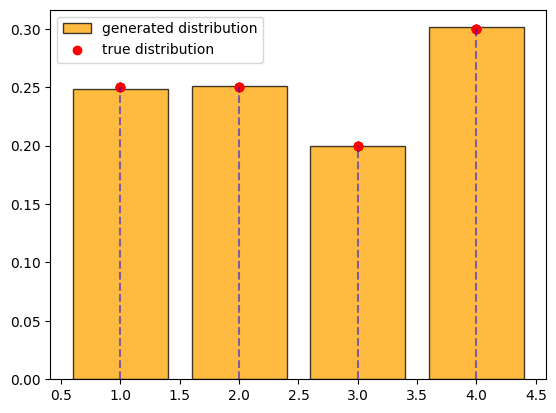

In [776]:
x = [1,2,3,4]
p = [1/4, 1/4, 1/5, 3/10]
N = 100000
X = gen_X(x, p, N)
plt.hist(X, bins= x + [x[-1] + 1], align='left', rwidth=0.8, alpha=0.75, facecolor='orange',edgecolor='k', density=True, label="generated distrib")

for i,j in zip(x,p):    
    plt.scatter(x,p, c='red')
    plt.plot([i,i], [0, j], color='blue', linestyle='--', alpha=0.5)
    
plt.legend(["generated distribution","true distribution"])
plt.show()

## Exercise 2: Gaussian mixture model and the EM algorithm

### Question 1:

(i) In the Gaussian mixture model there are 3 parameters of size $p$ (the number of clusters) : $\theta = (\alpha, \mu, \Sigma)$ where $\forall i \in \{1,..,n\}, \forall j \in \{1,..,p\}, \mathbb{P}(z_i = j) = \alpha_j$ and $X_i | \theta, \{z_i = j\} \sim \mathcal{N}(\mu_j, \Sigma_j)$.

We can write the probability density function $p_\theta(x)$ for an observation $x$ using the law of total probability :

$p_\theta(x_i) = \sum_{j=1}^{p} p_\theta(x_i | z_i = j)p_\theta(z_i) = \sum_{j=1}^{p} f_j(x_i)\alpha_j$ where $f_j$ is the probability density function of a gaussian variable with expectation $\mu_j$ and variance $\Sigma_j$.

We recall that $f_j(x) = \frac{1}{2\pi \sqrt{det\Sigma_j}}\exp(\frac{-1}{2}(x - \mu_j)^T\Sigma^{-1}(x - \mu_j))$

The likelihood function is : $\mathcal{L}(x_1,x_2,...,x_n ; \theta) = \prod_{i=1}^{n} p_\theta(x_i) = \prod_{i=1}^{n} \left( \sum_{j=1}^{p} f_j(x_i)\alpha_j\right)$.


(300, 2)


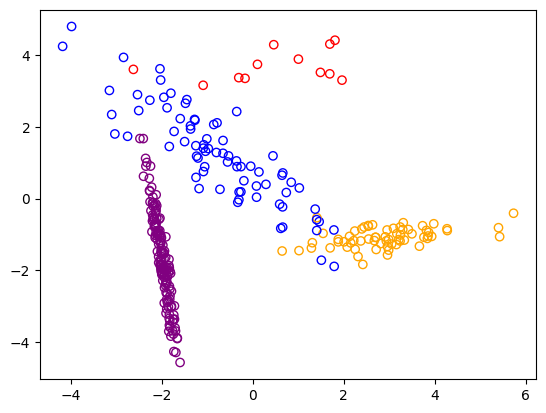

In [1712]:
np.random.seed(10)

X = np.random.normal(size=(2,2))
Y = np.random.normal(size=(2,2))
Z = np.random.normal(size=(2,2))
A = np.random.normal(size=(2,2))

mx = np.random.normal(loc=1.0, scale=1.5, size=2)
my = np.random.normal(loc=0.5, scale=1.5, size=2)
mz = np.random.normal(size=2)
ma = np.random.normal(loc=0, scale=1.5, size=2)

SigmaX = X @ X.T
SigmaY = Y @ Y.T
SigmaZ = Z @ Z.T
SigmaA = A @ A.T


N = 300
R = gen_X([1,2,3,4], [1/4,1/5,1/2,1/20], N) #use exercise 1

data = []
col = []
for r in R:
    if r==1:
        data.append(np.random.multivariate_normal(mean = mx, cov = SigmaX))
        col.append("blue")
    if r==2:
        data.append(np.random.multivariate_normal(mean = my, cov = SigmaY))
        col.append("orange")
    if r==3:
        data.append(np.random.multivariate_normal(mean = mz, cov = SigmaZ))
        col.append("purple")
    if r==4:
        data.append(np.random.multivariate_normal(mean = ma, cov = SigmaA))
        col.append("red")
        
    

data = np.array(data)
print(data.shape)
plt.scatter(data[:,0], data[:,1], facecolor='none', edgecolor=col)
plt.show()

### Question 3:
The $EM$ algorithm consists in repeating a two step algorithm :\
    $(E)$: Compute $Q$ : Where $Q(\theta | \theta_t) = \sum_{i = 1}^{n}\mathbb{E}_{z \sim p_{\theta_t}(z_i | x_i)}[\log p_\theta(z,x_i)]$\
    $(M)$: Maximise $Q$ such that $\theta_{t+1} = \underset{\theta}{arg max} \;Q(\theta | \theta_t)$
    
Now let's add detail :

$\forall i \in \{1,...,n\}, \forall j \in \{1,...,p\}, \; \log p_\theta(z_i = j, x_i) = \log p_\theta(x_i | z_i = j) + \log p_\theta(z_i = j) = \log f_j(x_i) + \log \alpha_j$

And using Bayes rule and the expression of $p_{\theta_t}(x_i)$ given above:

$\tau^t_{i,j} = p_{\theta_t}(z_i = j | x_i) = \frac{p_{\theta_t}(x_i | z_i = j)p_{\theta_t}(z_i = j)}{p_{\theta_t}(x_i)} = \frac{f^t_j(x_i)\alpha^t_j}{\sum_{k=1}^{p} f^t_k(x_i)\alpha^t_k}$

So given $\theta_t$ we can compute the (E) step by using the definition of the expectation $Q(\theta| \theta_t) = \sum_{i = 1}^{n}\mathbb{E}_{z \sim p_{\theta_t}(z_i | x_i)}[\log p_\theta(z,x_i)] = \sum_{i = 1}^{n}\sum_{j=1}^{p} (\log f_j(x_i) + \log \alpha_j) p_{\theta_t}(z_i = j |x_i) = \sum_{i = 1}^{n} \sum_{j=1}^{p} (\log f_j(x_i) + \log \alpha_j)\tau^t_{i,j}$

And what is of interest is primarily $\tau^t_{i,j}$.

Once the (E) step done we have to find a new $\theta_{t+1}$ by minimising the opposit of the above function with constraints :

$\underset{\alpha_j, \Sigma_j, \mu_j}{min} - \underset{\underset{i\in \{1,...,n\}}{j\in \{1,...,p\}}}{\sum} (\log f_j(x_i) + \log \alpha_j)\tau^t_{i,j}$ 

such that : $\sum_{j=1}^{p} \alpha_j = 1; 
-\alpha < 0; 
\forall j,\; \Sigma_j \in \mathcal{S}^+_d(\mathbb{R}) $

We can now determin the Lagrangian :

$L(\theta, \phi, \lambda) = - \underset{\underset{i\in \{1,...,n\}}{j\in \{1,...,p\}}}{\sum}   (\log f_j(x_i) + \log \alpha_j)\tau^t_{i,j} + \phi(\sum_{j=1}^{p} \alpha_j - 1) - \lambda^T\alpha$

The KKT conditions give us that $\lambda = 0$, so we just need to derive according to $\theta$ and minimize using the fact that we have a convex function because the Gaussian density is log concave and opposing gives us convexity (which is preserved when adding linear functions):

>$\dfrac{\partial L}{\partial \alpha_j} =  - \sum_{i = 1}^{n} \frac{\tau_{i,j}}{\alpha_j} + \phi_j= 0 \Leftrightarrow \alpha_j = \frac{1}{\phi}\sum_{i = 1}^{n} \tau^t_{i,j}$

And considering the constraint : $\sum_{j=1}^{p} \alpha_j = 1$ we have that $\sum_{j=1}^{p} \left( \frac{1}{\phi}\sum_{i = 1}^{n} \tau^t_{i,j} \right) = 1 \Leftrightarrow \phi = \sum_{i = 1}^{n} \sum_{j=1}^{p} \tau^t_{i,j} = \sum_{i = 1}^{n} 1 = n$

>$\dfrac{\partial L}{\partial \mu_j} = - \sum_{i=1}^{n}\Sigma_j^{-1}(\mu_j - x_i)\tau^t_{i,j} = 0 \Leftrightarrow \mu_j = \frac{\sum_{i=1}^{n}\tau^t_{i,j} x_i}{\sum_{i=1}^{n}\tau^t_{i,j}}$ 

>$\dfrac{\partial L}{\partial \Sigma^{-1}_j} = - \sum_{i=1}^{n} (\frac{1}{2}\Sigma_j - \frac{1}{2}(x_i - \mu_j)(x_i - \mu_j)^T)\tau^t_{i,j} = 0 \Leftrightarrow \Sigma_j = \frac{\sum_{i=1}^{n}(x_i - \mu_j)(x_i - \mu_j)^T\tau^t_{i,j}}{\sum_{i=1}^{n}\tau^t_{i,j}} = \frac{\sum_{i=1}^{n}x_ix_i^T\tau^t_{i,j}}{\sum_{i=1}^{n}\tau^t_{i,j}} + \mu_j\mu_{j}^{t+1^T}+\mu_j\mu_j^T$ we calculate the derivative according to the inverse of $\Sigma_j$ which is easier and gives us a good relation for $\Sigma_j$ that depends also on the newly updated mean $\mu_{j}^{t+1}$ obtained by the relation above.

So expressed clearly the updates at the $(M)$ step will be at time $t+1$ and for all class $j$:

>- $\alpha^{t+1}_{j} = \frac{1}{n}\sum_{i = 1}^{n} \tau^t_{i,j}$
-$\mu_j^{t+1} = \frac{\sum_{i=1}^{n}\tau^t_{i,j} x_i}{\sum_{i=1}^{n}\tau^t_{i,j}}$
-$\Sigma_j^{t+1} = \frac{\sum_{i=1}^{n}x_ix_i^T\tau^t_{i,j}}{\sum_{i=1}^{n}\tau^t_{i,j}} + \mu_j^t\mu_{j}^{t+1^T}+\mu_j^t\mu_j^{t^T} = \frac{\sum_{i=1}^{n}x^{c_j}_ix^{c_j^T}_i\tau^t_{i,j}}{\sum_{i=1}^{n}\tau^t_{i,j}}$ where $x^{c_j}_i$ are the centered data points according to the $j$ class mean.


In [1715]:
def f(x, mu, Sigma, d):
    return (1 / ((2 * np.pi)**(d/2)* np.linalg.det(Sigma)**(0.5)) )*np.exp(-0.5 * (x - mu).T @ np.linalg.inv(Sigma) @ (x - mu))


def EM(X, p, N):
    #initialisation
    eps = 1e-16 
    n, d = X.shape
    alpha = np.empty((p,))
    mu = np.empty((p,d))
    Sigma = np.empty((p,d,d))
    tau = np.empty((n,p))
    F = np.empty((n,p))
    for j in range(p):
        alpha[j] = (1/p)
        mu[j] = (np.random.normal(size=d))
        Y = np.eye(d)
        Sigma[j] = Y @ Y.T
    
    for t in range(N):
        #E step : and using the logsumexp trick
        for j in range(p):
            F[:, j] = np.array([f(x, mu[j], Sigma[j], d) for x in X])
        log_tau = np.log(F + eps) + np.log(alpha) - logsumexp(np.log(alpha) + np.log(F + eps), axis=1)[:, np.newaxis] 
        tau = np.exp(log_tau)
                   
    #M step :
        for j in range(p):
            alpha[j] = np.sum(tau[:,j]) / n
            X_cj = X - mu[j]            #center according to mu_j
            Sigma[j] = np.einsum("k, ki, kj -> ij", tau[:,j], X_cj, X_cj) / np.sum(tau[:,j])
            mu[j] = np.sum(X * tau[:,j][:,np.newaxis], axis=0) / np.sum(tau[:,j])
            
    return alpha,mu,Sigma
             
        
    

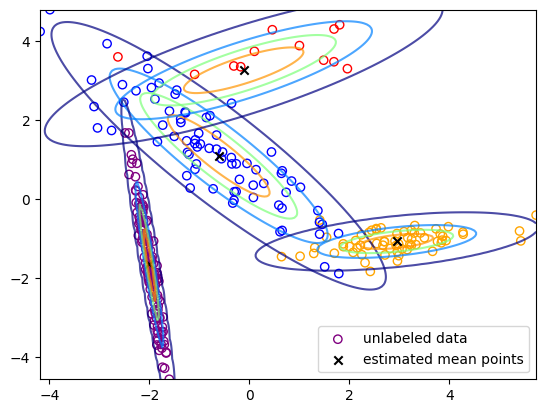

In [1716]:
p = 4
N = 30
alpha,mu,Sigma = EM(data, p, N)

plt.scatter(data[:,0], data[:,1], facecolor='none', edgecolor=col)
num_points = 200

d = 2
x = np.linspace(data[:,0].min(), data[:,0].max(), num_points)
y = np.linspace(data[:,1].min(), data[:,1].max(), num_points)  
X, Y = np.meshgrid(x, y)


for j in range(p):
    Z = np.array([[f(np.array([x, y]), mu[j], Sigma[j], d) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
    contours = plt.contour(X, Y, Z, levels=np.linspace(Z.mean(), Z.max(), 5), cmap='jet', linewidths=1.5, alpha =0.7)  # 'levels' determines the number of contour lines
    plt.scatter(mu[j][0], mu[j][1], marker='x', color='k')


plt.legend(["unlabeled data", "estimated mean points"])
plt.show()

This algorithm converges quite fast but sometimes we have to run it several times so that it detects well the different clusters because for instance the red one has very few points and the algorithm could consider it as noise of the blue distribution but on runs it does detect it well.

### Question 5

In [1594]:
import pandas as pd
from sklearn.model_selection import train_test_split
 
datafile = "./WPP2019_Period_Indicators_Medium.csv"

df = pd.read_csv(datafile)
    
print(df.columns)

Index(['LocID', 'Location', 'VarID', 'Variant', 'Time', 'MidPeriod', 'TFR',
       'NRR', 'CBR', 'Births', 'LEx', 'LExMale', 'LExFemale', 'IMR', 'Q5',
       'CDR', 'Deaths', 'DeathsMale', 'DeathsFemale', 'CNMR', 'NetMigrations',
       'GrowthRate', 'NatIncr', 'SRB', 'MAC'],
      dtype='object')


We are interested in the Crude Birth / Death Rate so the columns CBR and CDR. Let's extract them and work in 2d.

(13290, 2)


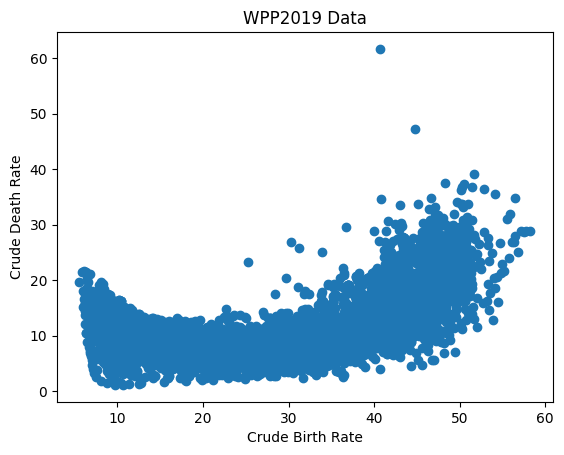

In [1718]:
data = df[['CBR', 'CDR']].dropna()
data = data.values

print(data.shape)
plt.scatter(data[:,0],data[:,1])
plt.xlabel("Crude Birth Rate")
plt.ylabel("Crude Death Rate")
plt.title('WPP2019 Data')
plt.show()

Looking at the shape of the data I believe we can cover it with several gaussians. On the right side we can imagin a gaussian with higher variance than on the left. But the data being very tight together we don't destinguish clearly several clusters. If we want to assign a GMM to this data, I believe that there are more than 2 gaussians needed to well explain it. We shall try it out for different numbers of classes.

### Question 6


In [1596]:
N = 20

parameters = []
P = np.arange(1, 8)

for p in P:
    alpha,mu,Sigma = EM(data, p, N)
    parameters.append([alpha, mu, Sigma])

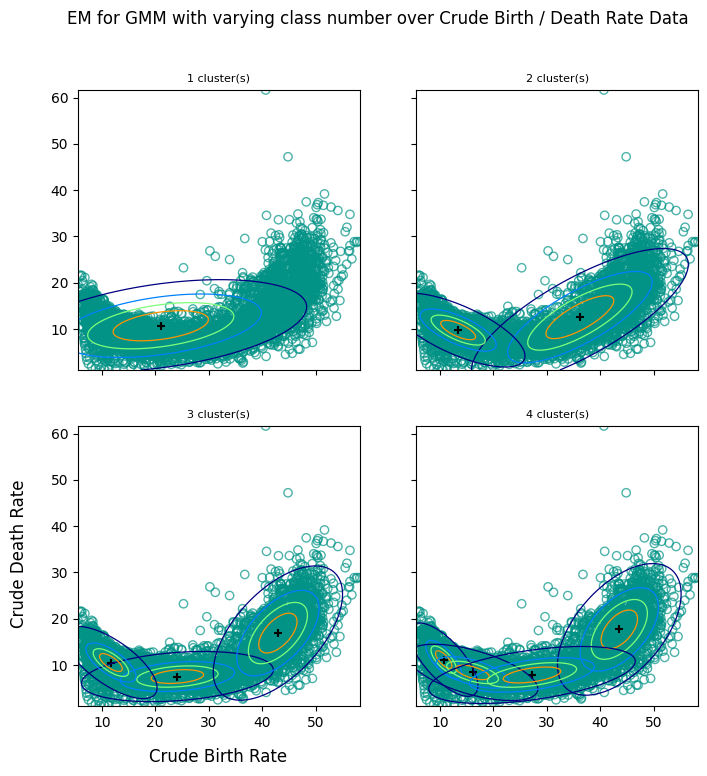

In [1597]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(8, 8))

num_points = 200

d = 2
x = np.linspace(data[:,0].min(), data[:,0].max(), num_points)
y = np.linspace(data[:,1].min(), data[:,1].max(), num_points)  
X, Y = np.meshgrid(x, y)

for ax,p in zip([ax1,ax2,ax3,ax4],[1,2,3,4]):
    ax.scatter(data[:,0],data[:,1],facecolor='none', edgecolor='#029386',alpha =0.7)
    for j in range(p):
        Z = np.array([[f(np.array([x, y]), parameters[p-1][1][j], parameters[p-1][2][j], d) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])
        contours = ax.contour(X, Y, Z, levels=np.linspace(Z.mean(), Z.max(), 5), cmap='jet', linewidths=0.9) 
        ax.set_title('{} cluster(s)'.format(p), fontsize=8)
        ax.scatter(parameters[p-1][1][j][0], parameters[p-1][1][j][1], marker='+', color='k')



#cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # Adjust the position and size of the colorbar
#cbar = plt.colorbar(contours, cax=cbar_ax)
#cbar.set_label('Density level contours')

plt.suptitle("EM for GMM with varying class number over Crude Birth / Death Rate Data")

fig.text(0.30, 0.04, "Crude Birth Rate", ha='center', fontsize=12)
fig.text(0.04, 0.30, "Crude Death Rate", va='center', rotation='vertical', fontsize=12)

plt.show()

    

We can now try to find the best number p of clusters to use by optimizing the BIC criterion.
We first need to determin the number of degrees of freedom of our model :
$\theta = (\alpha, \mu, \Sigma)$ where $\alpha \in \mathbb{R}^p$, $\mu \in \mathbb{R}^{d \times p}$ and $\Sigma \in \mathbb{R}^{p \times (d \times p)}$ is a hypermatrix of symmetric matrices. We consider that the $\alpha$ is of degree of freedom equal to p-1 sincethe last coefficient can be determined by all the others according to the constraint in the Lagrangian. We do also notice that since the covariance matrices are symmetric we have $\frac{d(d+1)}{2}$ degrees of freedom for each matrix.
Finally, $df(p) = p(1 + d + \frac{d(d+1)}{2}) - 1$ we just need to find the value of p that minimizes 

$BIC(p) = - \log \mathcal{L}(x_1, ..., x_n;\theta) + \frac{df(p)\log(n)}{2}$

Again we will use the logsumexp trick : 
$\mathcal{L}(x_1, ..., x_n;\theta) = \prod_{i=1}^{n} \left( \sum_{j=1}^{p} f_j(x_i)\alpha_j\right) =\prod_{i=1}^{n} \exp(\log \sum_{j=1}^{p} \exp \left(\log f_j(x_i) + \log\alpha_j\right) = \exp\left(\sum_{i=1}^{n} \log \sum_{j=1}^{p} \exp (\log f_j(x_i) + \log \alpha_j)\right)$

>So we have that : $\log \mathcal{L}(x_1, ..., x_n;\theta) = \sum_{i=1}^{n} \text{logsumexp} (\log f_j(x_i) + \log \alpha_j)$

In [1678]:
def calc_BIC(X, p, params):
    eps = 1e-16
    n, d = X.shape
    log_F_alpha = np.empty((n,p))
    for j in range(p):
        log_gamma = -(d * np.log(2 * np.pi)/2 + np.linalg.slogdet(params[p-1][2][j])[1]/2)
        log_exp = -np.einsum("ik, il, kl -> i", X - params[p-1][1][j],X - params[p-1][1][j], np.linalg.inv(params[p-1][2][j]))/2
        log_F_alpha[:,j] = log_gamma + log_exp + np.log(params[p-1][0][j])
        
    dfp = p*(1 + d + d*(d+1)/2)
    L = logsumexp(log_F_alpha , axis=1)
    pen = dfp * np.log(n) / 2
    print("The penalisation for p = {} is {}".format(p,pen))
    return -L.sum() + pen

The penalisation for p = 1 is 28.484301455121873
The penalisation for p = 2 is 56.968602910243746
The penalisation for p = 3 is 85.45290436536563
The penalisation for p = 4 is 113.93720582048749
The penalisation for p = 5 is 142.42150727560937
The penalisation for p = 6 is 170.90580873073125
The penalisation for p = 7 is 199.39011018585313



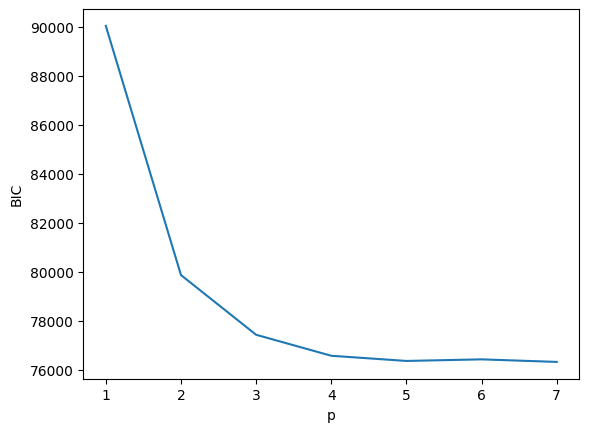

In [1679]:
BIC = []
for p in P:
    BIC.append(calc_BIC(data, p, parameters))
plt.plot(P, BIC)
plt.xlabel('p')
plt.ylabel('BIC')

print()

Looking at the penalization and the values of the BIC it seems that there is an issue, since the penalisation is very small against the BIC value the BIC is decreasing. Maybe that for higher values it increases again or either I have miscalculated the degrees of freedom.

Let's plot the contour with the best number of clusters given by the BIC:

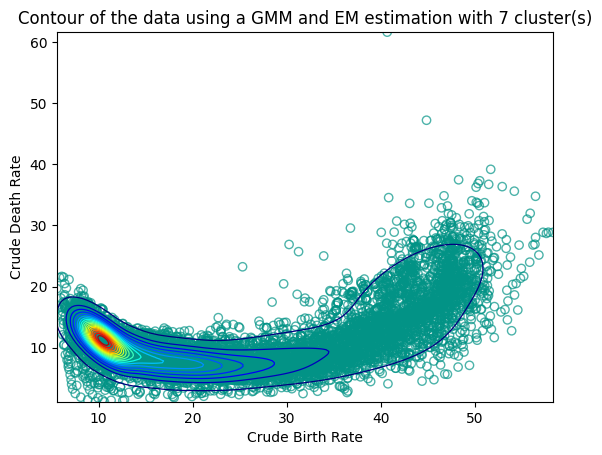

In [1723]:
num_points = 200
p = np.argmin(BIC) + 1
d = 2
x = np.linspace(data[:,0].min(), data[:,0].max(), num_points)
y = np.linspace(data[:,1].min(), data[:,1].max(), num_points)  
X, Y = np.meshgrid(x, y)
Z = np.array([[np.sum([parameters[p-1][0][j] * f(np.array([x, y]), parameters[p-1][1][j], parameters[p-1][2][j], d) for j in range(p)]) for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

plt.title("Contour of the data using a GMM and EM estimation with {} cluster(s)".format(p))
plt.scatter(data[:,0],data[:,1],facecolor='none', edgecolor='#029386',alpha =0.7)

plt.contour(X, Y, Z, levels=np.linspace(Z.mean(), Z.max(), 20), cmap='jet', linewidths=0.9)
plt.xlabel("Crude Birth Rate")
plt.ylabel("Crude Death Rate")
plt.show()

## Exercise 3: Importance sampling

### 3.A – Poor Importance Sampling

### Question 1

In [1682]:
p = lambda x : x**(0.65) * np.exp(-x**2 / 2)
q = lambda x,mu : (2/np.sqrt(2 * np.pi * 1.5)) * np.exp(-(mu - x)**2/(2 * 1.5))  #scaled gaussian density of N(0.8, 1.5)
f = lambda x : 2*np.sin(2 * np.pi / 3 * x)

q = np.vectorize(q)

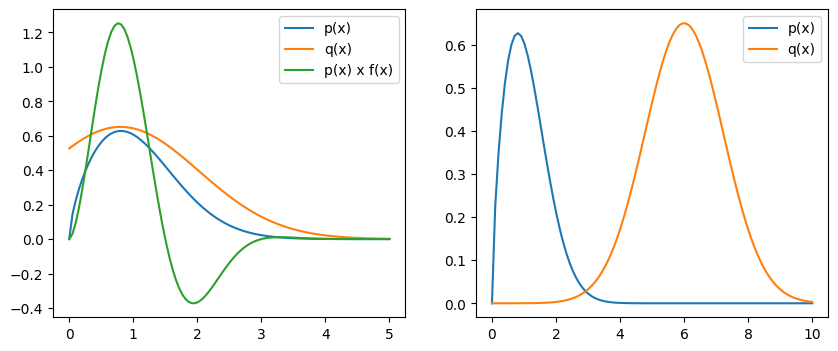

In [1683]:
x1 = np.linspace(0, 5, 100)
x2 = np.linspace(0, 10, 100)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))

ax1.plot(x1, p(x1),label="p(x)")
ax1.plot(x1, q(x1, 0.8),label="q(x)")
ax1.plot(x1, p(x1) * f(x1),label="p(x) x f(x)")


ax1.legend()

ax2.plot(x2, p(x2),label="p(x)")
ax2.plot(x2, q(x2, 6),label="q(x)")

ax2.legend()
plt.show()

We want to estimate $\int f(x)p(x) dx = \mathbb{E}_{X \sim p}[f(X)]$ by applying Importance Sampling : ie estimating $\mathbb{E}_{X \sim q}\left[f(X)\frac{p(X)}{q(X)}\right]$ instead since simulating for $q$ is easier (it is a gaussian density) this by using MC estimator : $\hat{\mu}_N = \frac{1}{N} \sum_{i = 1}^{N} f(X_i)\frac{p(X_i)}{q(X_i)} = \frac{1}{N} \sum_{i = 1}^{N} f(X_i)w(X_i)$.

But in fact what is above is wrong since $p$ and $q$ are not proper densities and require normalizing (we will note the densities $c_p \tilde{p} = p$ and $c_q\tilde{q} = q$. So  we will use the normalized importance weights $\tilde{w_i} = \frac{w(X_i)}{ \frac{1}{N}\sum_{k=1}^{N} w(X_k)}$ that come again from the transfer theorem and MC: $\int f(x)p(x) dx = \frac{\int f(x)p(x) dx}{\int \tilde{p}(x) dx} = \frac{\int f(x)\frac{c_p\tilde{p}(x)}{q(x)}c_q\tilde{q}(x) dx}{\int \frac{c_p\tilde{p}(x)}{q(x)}c_q\tilde{q}(x) dx} = \frac{\int f(x)w(x)\tilde{q}(x) dx}{\int w(x)\tilde{q}(x) dx} = \frac{\mathbb{E}_{X \sim \tilde{q}}[f(X)w(X)]}{\mathbb{E}_{X \sim \tilde{q}}[w(X)]}$. 

And approximated by MC we have : $\int f(x)p(x) dx \approx \frac{\frac{1}{N} \sum_{i=1}^{N} f(X_i)w(X_i)}{\frac{1}{N} \sum_{i=1}^{N} w(X_i)} = \frac{\sum_{i=1}^{N} f(X_i)w(X_i)}{\sum_{i=1}^{N} w(X_i)} = \sum_{i=1}^{N} f(X_i)\tilde{w}(X_i)$

So what we just have to do now is sample from the real normal density $\tilde{q}$ and we will get the right result by applying the normalized Importance Sampling method.

In [1684]:
def NormalizedImportanceSampling(f, p, q, X, mu):
    N = len(X)
    w = p(X)/q(X,mu)
    return np.sum(f(X)*w)/ np.sum(w), w/ np.sum(w)

In [1685]:
mu = 0.8
sigma = 1.5
estimates = []
weights = []
N = [10,100,1000,10000]
for n in N:
    X = np.random.normal(mu,sigma,size=n) #q tilde
    X = np.abs(X)
    est, wn = NormalizedImportanceSampling(f,p,q,X,mu)
    estimates.append(est)
    weights.append(wn)
    

print(estimates)

[0.9259866545590877, 0.6706301444706584, 0.8409389891012202, 0.8021172437520663]


### Question 2:

Let's determine the mean and variance of our estimator by sampling several times the N variables :

In [1686]:
K = 100
for n in N:
    est_k = []
    for k in range(K):
        X = np.random.normal(mu,sigma,size=n) #q tilde
        X = np.abs(X)
        est, wn = NormalizedImportanceSampling(f,p,q,X,mu)
        est_k.append(est)
    est_k = np.array(est_k)
    print("For {} samples we have a mean of {} and a variance of {}".format(n, est_k.mean(), est_k.var()))

For 10 samples we have a mean of 0.7223760616769818 and a variance of 0.17879293765134477
For 100 samples we have a mean of 0.8100725050884001 and a variance of 0.013281483315860041
For 1000 samples we have a mean of 0.807586980643665 and a variance of 0.0014002317948101355
For 10000 samples we have a mean of 0.8069873170155507 and a variance of 0.00012995366694257295


We see that our estimator goes to 0.80 which is very close to the value 0.79 (approximated on Wolfram Alpha) and the variance goes to 0. The estimator seems empirically to be a good one.

### Question 3:

In [1687]:
mu = 6
sigma = 1.5
estimates_mu6 = []
weights_mu6 = []
N = [10,100,1000,10000]
for n in N:
    X = np.random.normal(mu,sigma,size=n) #q tilde
    X = np.abs(X)
    est, wn = NormalizedImportanceSampling(f,p,q,X,mu)
    estimates_mu6.append(est)
    weights_mu6.append(wn)
    
print(estimates_mu6)

[-1.450133368473749, -1.8607828286121058, 0.9459370184241929, 1.2772179095404022]


Running this several times we always get values that are far from what we had in the previous question, this is due to the fact that $q$ is not covering the mass of $p$ as we can see on the plot.

In [1688]:
for i in range(len(N)):
    print("For {} samples the distance between the weights is : {}".format(N[i],np.linalg.norm(np.array(weights_mu6[i]) - np.array(weights[i]))))

For 10 samples the distance between the weights is : 0.9147562846481181
For 100 samples the distance between the weights is : 0.6574197025551515
For 1000 samples the distance between the weights is : 0.7950962371409276
For 10000 samples the distance between the weights is : 0.4128936523905673


We see now why this doesn't work well, the importance weights are not close at all and thus we don't charge the same values of f in the estimation and thus approximate it's values badly and this causes a bad approximation for the integral.  

## 3.B – Adaptive Importance Sampling

### Question 4
We would like to solve the equation $\theta^* = \underset{\theta = (\alpha_i, \mu_i, \Sigma_i)_{i=1,..,K}}{argmax} \mathbb{E}_\nu[\log q_\theta(X)] = \underset{\theta = (\alpha_i, \mu_i, \Sigma_i)_{i=1,..,K}}{argmax} \mathbb{E}_{q_\theta}[\log q_\theta(X) \frac{\nu(X)}{q_\theta(X)}] = \underset{\theta = (\alpha_i, \mu_i, \Sigma_i)_{i=1,..,K}}{argmax} \mathbb{E}_{q_\theta}[\log q_\theta(X) w(X)]$ to do so we will apply the $\textit{Population Monte Carlo Algorithm}$ that is given. Again we have to be careful with the fact that $\nu$ is not a density but is proportional to one, so we will consider the normalized weights.

We can then notice in the algorithm that the maximization at step $(iii)$ is very similar to what the above EM solves.

To recognise all this we relax the problem by adding latent variables $Z_i$ in $\{1,..,K\}$. And we can write :

Using the MC estimator we have that taking $(X_i)_{i=1,...,N}$ iid variables of density $q_\theta(X)$ : $\theta^* \approx \underset{\theta = (\alpha_i, \mu_i, \Sigma_i)_{i=1,..,K}}{argmax} \frac{1}{N} \sum_{i=1}^{N} \log q_\theta(X_i) \tilde{w}(X_i)$ 

We recall that this kind of problem is invariant to positive constant multiplication by N and like we did before we consider the densities $p_{\theta_t}(z |X_i)$ we will use the Jensen inequality to find :

$$
\begin{align*}
\sum_{i=1}^{N} \log q_\theta(X_i) \tilde{w}(X_i) = \sum_{i=1}^{N} \log \left(\sum_{j=1}^K q_\theta(Z_i=j, X_i)\right) \tilde{w}(X_i) &= \sum_{i=1}^{N} \log \left(\sum_{j=1}^K \frac{q_\theta(Z_i=j, X_i)}{p_{\theta_t}(Z_i|X_i)}p_{\theta_t}(Z_i|X_i)\right) \tilde{w}(X_i) \\
&= \sum_{i=1}^{N}  \log  \mathbb{E}_{Z_i \sim p_{\theta_t}(Z|X_i)}\left[\frac{q_\theta(Z_i, X_i)}{p_{\theta_t}(Z_i|X_i)}\right] \tilde{w}(X_i) \\
&\geq \sum_{i=1}^{N}    \mathbb{E}_{Z_i \sim p_{\theta_t}(Z|X_i)}\left[\log \frac{q_\theta(Z_i, X_i)}{p_{\theta_t}(Z_i|X_i)} \right]\tilde{w}(X_i)\\
&=  \sum_{i=1}^{N}    \mathbb{E}_{Z_i \sim p_{\theta_t}(Z|X_i)}\left[\log q_\theta(Z_i, X_i) -\log p_{\theta_t}(Z_i|X_i) \right]\tilde{w}(X_i)
\end{align*}
$$

Since $p_{\theta_t}(.|X_i)$ is a density it is in [0,1] so $-\log p_{\theta_t}(Z_i|X_i)$ is positive and since we are maximising for $\theta$ we can allow ourselves to only consider : $\sum_{i=1}^{N}    \mathbb{E}_{Z_i \sim p_{\theta_t}(Z|X_i)}\left[w(X_i)\log q_\theta(Z_i, X_i) \right]$ which is the same problem as the original EM for GMM but with multiplicative weights . 

So in the PMC we just generate data according to the current distribution and then use the EM algorithm where we have the following updates where $\tilde{\tau}^t_{i,j} = \tilde{w}^t_i \tau^t_{i,j}$: 

>- $\alpha^{t+1}_{j} = \frac{1}{\sum_{i=1}^{n} \tilde{w}^t(X_i) }\sum_{i = 1}^{n} \tilde{\tau}^t_{i,j} = \sum_{i = 1}^{n} \tilde{\tau}^t_{i,j}$
-$\mu_j^{t+1} = \frac{\sum_{i=1}^{n}\tilde{\tau}^t_{i,j} x_i}{\sum_{i=1}^{n}\tilde{\tau}^t_{i,j}}$
-$\Sigma_j^{t+1}  = \frac{\sum_{i=1}^{n}x^{c_j}_ix^{c_j^T}_i\tilde{\tau}^t_{i,j}}{\sum_{i=1}^{n}\tilde{\tau}^t_{i,j}}$ where $x^{c_j}_i$ are the centered data points according to the $j$ class mean.

What is also important is the initialisation, we have to consider the same issues in the badly covered case above, where we have to start with clusters that cover well the density $\nu$ and since it is proportional to a d-dimensional centered normal with a modified second coefficient we must have the initial means set very close to 0 (not 0 exactly else the algorithm will give the same mean values for all clusters).

### 3.C – Application to a "banana"-shaped density

### Question 5


We are given a density $\nu$ and want to be able to sample from it. To do so we will try to find the best gaussian mixture density that approaches $\nu$ by using the PMC algorithm to find the best parameters.

In [1724]:
def f(x, mu, Sigma, d):
    return (1 / ((2 * np.pi)**(d/2)* np.linalg.det(Sigma)**(0.5)) )*np.exp(-0.5 * (x - mu).T @ np.linalg.inv(Sigma) @ (x - mu))



def EM_step(X, K, N, sigma, b, alpha, mu, Sigma):
    #initialisation
    eps = 1e-16 
    n, d = X.shape
    Cov_inv = np.eye(d)
    Cov_inv[0][0] = 1/sigma**2
    for t in range(N):
        #E step : and using the logsumexp trick
        log_Nu = np.empty((n,))
        
        X_mod = np.copy(X)
        X_mod[:,1] = X[:,1] + b*(X[:,0]**2 - sigma**2)
        
        log_gamma = -(d * np.log(2 * np.pi) /2 + np.log(sigma))
        log_exp = -np.einsum("ik, il, kl -> i", X_mod,X_mod,Cov_inv)/2
        log_Nu = log_gamma + log_exp
           
        log_F_alpha = np.empty((n,K))
        for j in range(K):
            log_gamma = -(d * np.log(2 * np.pi)/2 + 0.5*np.linalg.slogdet(Sigma[j])[1])
            log_exp = -np.einsum("ik, il, kl -> i", X - mu[j], X - mu[j], np.linalg.inv(Sigma[j]))/2 
            log_F_alpha[:,j] = log_gamma + log_exp + np.log(alpha[j] +eps)
        
        log_q_theta = logsumexp(log_F_alpha, axis=1)
        log_w = log_Nu - log_q_theta
        log_w = log_w - logsumexp(log_w)
        log_tau = log_F_alpha - np.tile(log_q_theta[:,np.newaxis], (1, K)) 
        
        log_tau_tilde = log_tau + np.tile(log_w[:,np.newaxis], (1, K)) 
        
        tau = np.exp(log_tau_tilde)  
        
    #M step :
        for j in range(K):
            alpha[j] = tau[:,j].sum()
            #print("a_{} : {}".format(j, alpha[j]))
            X_cj = X - mu[j]            #center according to mu_j
            Sigma[j] = np.einsum("nd,nk->dk", X_cj, X_cj * tau[:,j][:,np.newaxis]) / (alpha[j]+eps)
            mu[j] = np.sum(X * tau[:,j][:,np.newaxis], axis=0) / (alpha[j]+eps)
    return alpha,mu,Sigma

def Adaptive_ImportanceSampling(d, n, sigma, K, num_iter, num_EM_iter, b):
    #initialisation
    eps = 1e-16 
    alpha = np.empty((K,))
    mu = np.empty((K,d))
    Sigma = np.empty((K,d,d))
    for j in range(K):
        alpha[j] = (1/K)
        mu[j] = np.random.normal(size=d)/10
        Sigma[j] = np.eye(d)
    #call num_iter times the EM step
    for l in range(num_iter):
        #sample from the current distrib
        X = []
        k = gen_X(np.arange(K), alpha, n)
        for i in k:
            X.append(np.random.multivariate_normal(mu[i], Sigma[i]))
        X = np.array(X)
        #call EM algorithm
        alpha, mu, Sigma = EM_step(X, K, num_EM_iter, sigma, b, alpha, mu, Sigma)
    return X, alpha, mu, Sigma
    

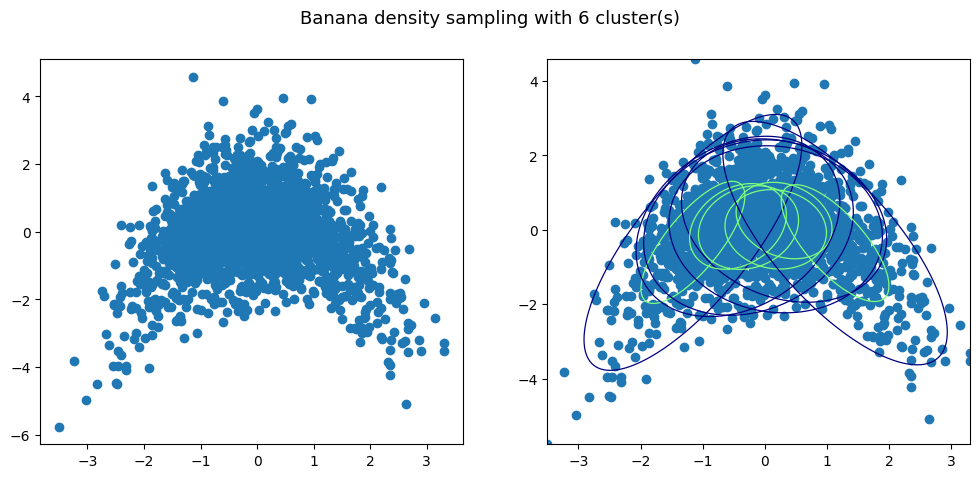

In [1725]:
n= 2000
K = 6
X, alpha, mu, Sigma = Adaptive_ImportanceSampling(d=5, n=n, sigma=1, K=K, num_iter=60, num_EM_iter=1, b=0.4)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle("Banana density sampling with {} cluster(s)".format(K),fontsize=13, ha='center')

ax1.scatter(X[:,0],X[:,1])

x = np.linspace(X[:,0].min(), X[:,0].max(), num_points)
y = np.linspace(X[:,1].min(), X[:,1].max(), num_points)  
X_, Y_ = np.meshgrid(x, y)
for j in range(K):
    Z = np.array([[[alpha[j] * f(np.array([x, y]), mu[j][:2], Sigma[j][:2,:2], 2)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X_, Y_)]).reshape(num_points,num_points)
    ax2.contour(X_, Y_, Z, levels=np.linspace(Z.mean(), Z.max(), 3), cmap='jet', linewidths=0.9)



ax2.scatter(X[:,0],X[:,1])
plt.show()

We see appear the wanted banana density ! Let's modify b to have a nicer one :

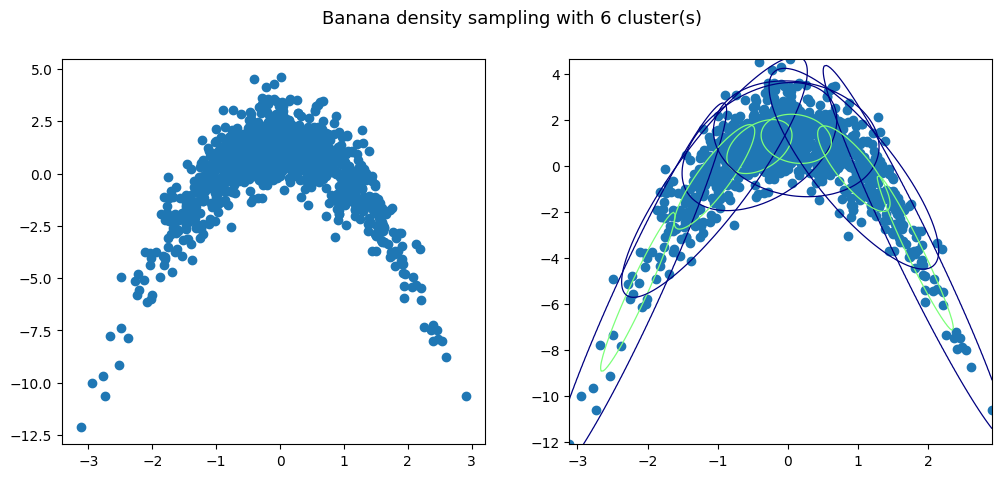

In [1727]:
n= 1000
K = 6
X, alpha, mu, Sigma = Adaptive_ImportanceSampling(d=5, n=n, sigma=1, K=K, num_iter=60, num_EM_iter=1, b=1.5)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle("Banana density sampling with {} cluster(s)".format(K),fontsize=13, ha='center')

ax1.scatter(X[:,0],X[:,1])

x = np.linspace(X[:,0].min(), X[:,0].max(), num_points)
y = np.linspace(X[:,1].min(), X[:,1].max(), num_points)  
X_, Y_ = np.meshgrid(x, y)
for j in range(K):
    Z = np.array([[[alpha[j] * f(np.array([x, y]), mu[j][:2], Sigma[j][:2,:2], 2)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(X_, Y_)]).reshape(num_points,num_points)
    ax2.contour(X_, Y_, Z, levels=np.linspace(Z.mean(), Z.max(), 3), cmap='jet', linewidths=0.9)



ax2.scatter(X[:,0],X[:,1])
plt.show()

On this final cell I can proudly say that I can use Adaptive importance sampling to sample on a 2D banana, and chose it's shape !